# Import Library

In [ ]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from PIL import Image

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
csv_path = '/content/drive/MyDrive/Dataset/attention.csv'
img_dir = '/content/drive/MyDrive/Dataset/datasets/'

df = pd.read_csv(csv_path)
df['label'] = df['label'].astype(int)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Balancing Dataset

In [ ]:
min_class_count = max(Counter(df['label']).values())
augmented_df = df.copy()

for label in df['label'].unique():
    subset = df[df['label'] == label]
    augment_size = min_class_count - len(subset)
    if augment_size > 0:
        augment_sample = subset.sample(augment_size, replace=True)
        augmented_df = pd.concat([augmented_df, augment_sample], ignore_index=True)

augmented_df = augmented_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Encode Labels

In [ ]:
y_all = to_categorical(augmented_df['label'], num_classes=5)

# Split Dataset

In [ ]:
X_train_fn, X_val_fn, y_train, y_val = train_test_split(
    augmented_df['filename'], y_all, test_size=0.2, stratify=y_all, random_state=42)

# Dataset Pipeline

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def decode_image(filename, label, augment=False):
    path = tf.strings.join([img_dir, filename])
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)
    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_saturation(img, 0.8, 1.2)
        img = tf.image.random_hue(img, 0.02)
    return img, label

def create_dataset(filenames, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((filenames, labels))
    ds = ds.map(lambda x, y: decode_image(x, y, augment=training), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(1024)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = create_dataset(X_train_fn.values, y_train, training=True)
val_ds = create_dataset(X_val_fn.values, y_val, training=False)

# Model Modification

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2),
], name="data_augmentation")

input_layer = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(input_layer)
x = preprocess_input(x)

base_model = EfficientNetB0(include_top=False, input_tensor=x, weights='imagenet')
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(5, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,219,816 (16.10 MB)

 Trainable params: 167,429 (654.02 KB)

 Non-trainable params: 4,052,387 (15.46 MB)

# Train Model

In [ ]:
early_stop = EarlyStopping(patience=7, restore_best_weights=True, monitor='val_loss')
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1)

history = model.fit(train_ds, validation_data=val_ds, epochs=80, callbacks=[early_stop, lr_schedule])

Epoch 1/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 569ms/step - accuracy: 0.2221 - loss: 2.8575 - val_accuracy: 0.3097 - val_loss: 1.7654 - learning_rate: 0.0010
Epoch 2/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.3602 - loss: 2.2528 - val_accuracy: 0.3805 - val_loss: 1.6933 - learning_rate: 0.0010
Epoch 3/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.3784 - loss: 2.0207 - val_accuracy: 0.4690 - val_loss: 1.6365 - learning_rate: 0.0010
Epoch 4/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.3736 - loss: 2.0676 - val_accuracy: 0.4336 - val_loss: 1.6125 - learning_rate: 0.0010
Epoch 5/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.3927 - loss: 1.8562 - val_accuracy: 0.4513 - val_loss: 1.5762 - learning_rate: 0.0010
Epoch 6/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.4178 - loss: 1.7367 - val_accuracy: 0.4690 - val_loss: 1.5307 - learning_rate: 0.0010
Epoch 7/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.4966 - loss: 1.6612 -

# Evaluation & Visualization

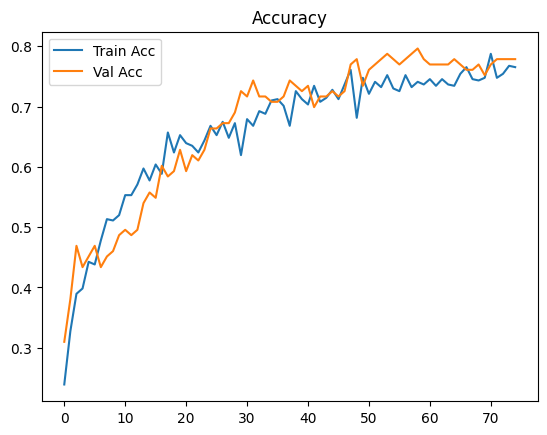

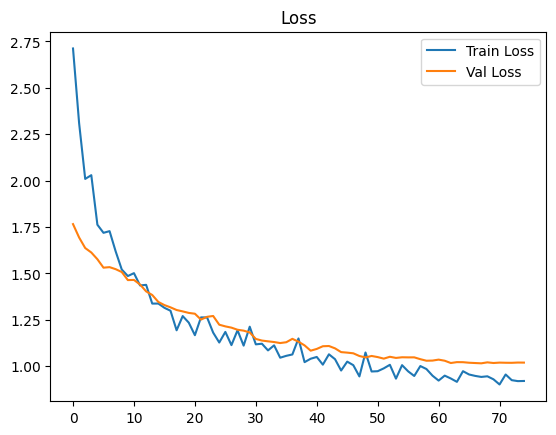

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy'); plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss'); plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 898ms/step
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        22
           1       0.71      0.87      0.78        23
           2       0.71      0.65      0.68        23
           3       0.72      0.82      0.77        22
           4       0.79      0.48      0.59        23

    accuracy                           0.76       113
   macro avg       0.76      0.76      0.75       113
weighted avg       0.76      0.76      0.75       113



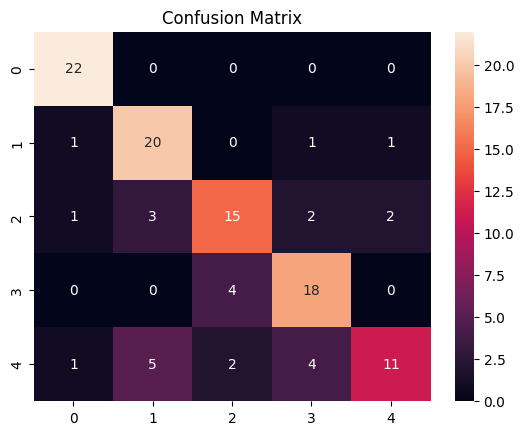

In [ ]:
val_images = np.concatenate([x for x, _ in val_ds], axis=0)
y_true = np.argmax(np.concatenate([y for _, y in val_ds], axis=0), axis=1)
y_pred = np.argmax(model.predict(val_images), axis=1)

print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix"); plt.show()

In [ ]:
loss, acc = model.evaluate(val_ds)
print(f"\n✅ Final Validation Accuracy: {acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.7419 - loss: 1.0306

✅ Final Validation Accuracy: 0.7611


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Skala Likert Prediksi: 1 (Probabilitas: 0.96)


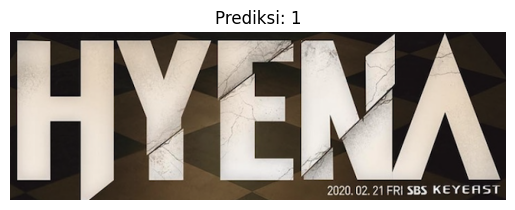

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Skala Likert Prediksi: 2 (Probabilitas: 0.37)


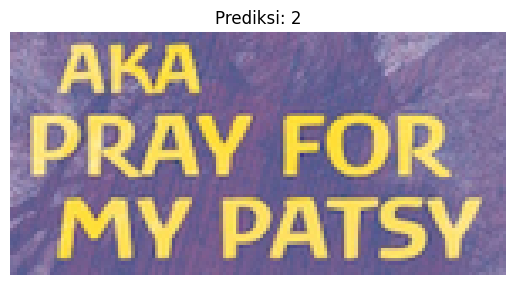

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Skala Likert Prediksi: 3 (Probabilitas: 0.88)


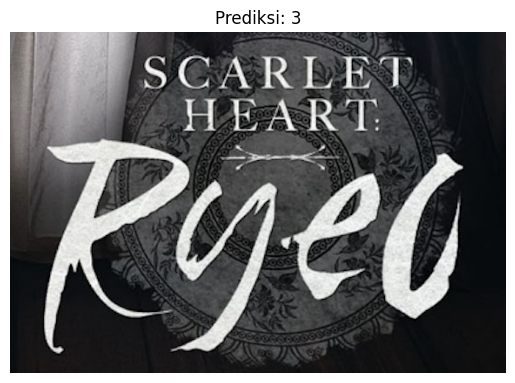

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Skala Likert Prediksi: 4 (Probabilitas: 0.83)


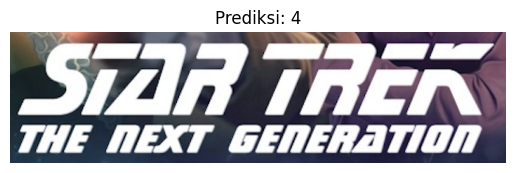

In [ ]:
def predict_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)
    img = tf.expand_dims(img, 0)

    pred = model.predict(img)
    pred_label = np.argmax(pred, axis=1)[0]
    print(f"Skala Likert Prediksi: {pred_label} (Probabilitas: {pred[0][pred_label]:.2f})")

    plt.imshow(tf.cast(tf.image.decode_image(tf.io.read_file(img_path), channels=3), tf.uint8))
    plt.axis('off')
    plt.title(f"Prediksi: {pred_label}")
    plt.show()

predict_image('52-1.png')
predict_image('2-2.png')
predict_image('61-3.png')
predict_image('8-4.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Skala Likert Prediksi: 4 (Probabilitas: 0.68)


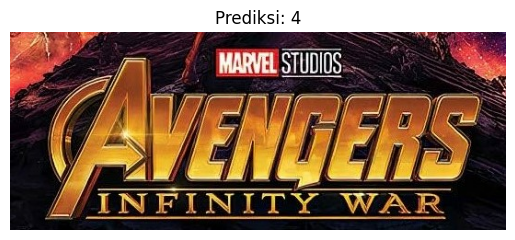

In [ ]:
predict_image('tes1.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Skala Likert Prediksi: 2 (Probabilitas: 0.61)


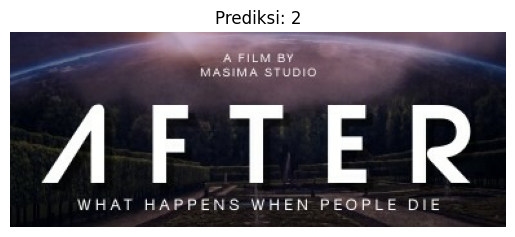

In [ ]:
predict_image('tes2.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Skala Likert Prediksi: 4 (Probabilitas: 0.60)


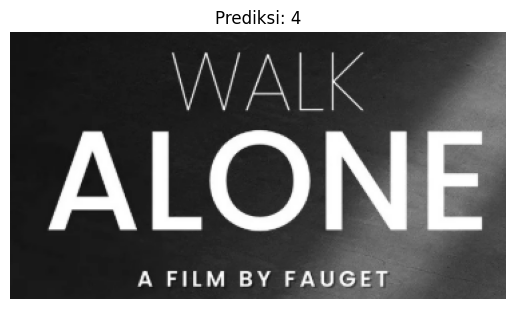

In [ ]:
predict_image('tes3.png')